# Clasificación de cantos de pájaros ( Mirlos, Arrendajos y Carboneros)

Francisco Rodríguez Cuenca

The audio samples were obtained from:

* https://www.xeno-canto.org

And the crawler was modified from this example:

 * [birdsonearth](https://github.com/birds-on-mars/birdsonearth/blob/master/datasets/birdsounds.py)


### Preprocessing stage 

In [1]:
import librosa 
from scipy.io import wavfile as wav
import numpy as np

#### Sample Rate

In [2]:
filename = 'data/10birds/Turdus/1352.wav' 

librosa_audio, librosa_sample_rate = librosa.load(filename) 
scipy_sample_rate, scipy_audio = wav.read(filename) 

print('Original sample rate:', scipy_sample_rate) 
print('Librosa sample rate:', librosa_sample_rate) 

Original sample rate: 22050
Librosa sample rate: 22050


#### Bit-depth 

In [3]:
print('Original audio file min~max range:', np.min(scipy_audio), 'to', np.max(scipy_audio))
print('Librosa audio file min~max range:', np.min(librosa_audio), 'to', np.max(librosa_audio))

Original audio file min~max range: -12746 to 14535
Librosa audio file min~max range: -0.38897705 to 0.443573


#### Merge audio channels 

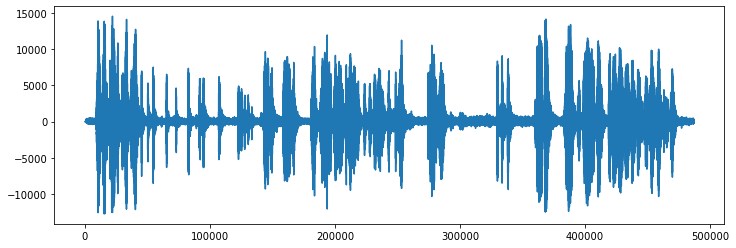

In [4]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

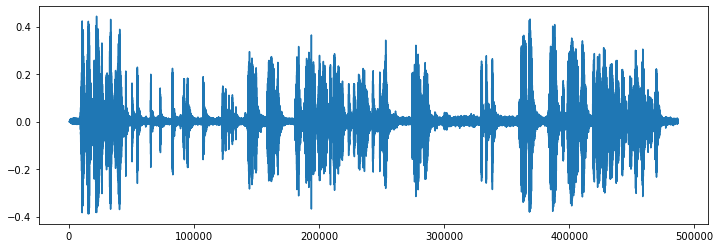

In [5]:
# Librosa audio with channels merged 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio)

### Extract Features 

#### Extracting a MFCC

In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio, sr=librosa_sample_rate, n_mfcc=40)  #from the literature the first 13th are the most representative
print(mfccs.shape) #That's 173 samples and 40 Mel-frequency cepstral coefficients

(40, 951)


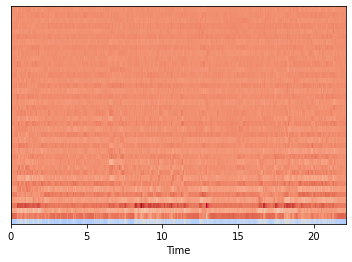

In [7]:
import librosa.display
librosa.display.specshow(mfccs, sr=librosa_sample_rate, x_axis='time')

#### Extracting MFCC's for every file 

In [8]:
import pandas as pd
import os
import librosa
from glob import glob

In [9]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')  #kaiser_fast - high resolution
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [10]:
carbonero = glob(pathname="data/10birds/Parus/*")
mirlo = glob(pathname="data/10birds/Turdus/*")
arrendajo = glob(pathname="data/10birds/Garrulus/*")

In [11]:
data = (
    list(map(lambda path : ("Carbonero", extract_features(path)), carbonero)) + 
    list(map(lambda path : ("Mirlo", extract_features(path)), mirlo)) + 
    list(map(lambda path : ("Arrendajo", extract_features(path)), arrendajo))
)

/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [12]:
featuresdf = pd.DataFrame(data, columns= ["class_label", "feature"], )
featuresdf

,class_label,feature
0,Carbonero,"[-512.55927, 45.171978, 11.400741, 44.23818, 5..."
1,Carbonero,"[-588.4902, 1.3267289, -3.036135, 9.091025, -1..."
2,Carbonero,"[-341.96182, 99.5176, -15.277686, 10.666541, -..."
3,Carbonero,"[-307.98322, 18.405989, -14.905345, -1.4368179..."
4,Carbonero,"[-448.7659, 19.839348, -12.141717, 30.371658, ..."
...,...,...
1436,Arrendajo,"[-379.0589, 72.06425, -43.798336, -23.38201, -..."
1437,Arrendajo,"[-302.92432, 60.98192, -43.70341, 9.114791, -1..."
1438,Arrendajo,"[-332.45734, 54.379097, -35.348785, 7.796014, ..."
1439,Arrendajo,"[-403.32278, -75.939156, -75.14334, -4.367598,..."


In [13]:
featuresdf.class_label.unique()

array(['Carbonero', 'Mirlo', 'Arrendajo'], dtype=object)

### Convert the data and labels

In [14]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

### Split the dataset


In [15]:
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

### Initial model architecture - MLP


In [16]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu')) #sigmoid
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu')) #sigmoid 
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

### Compiling the model 

In [17]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [18]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               10496     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 7

### Training 


In [19]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

s 2ms/step - loss: 1.1858 - accuracy: 0.4288 - val_loss: 1.0944 - val_accuracy: 0.3426

Epoch 00010: val_loss did not improve from 1.04967
Epoch 11/100
36/36 [==============================] - 0s 2ms/step - loss: 1.1745 - accuracy: 0.4097 - val_loss: 1.0953 - val_accuracy: 0.3460

Epoch 00011: val_loss did not improve from 1.04967
Epoch 12/100
36/36 [==============================] - 0s 2ms/step - loss: 1.1567 - accuracy: 0.4505 - val_loss: 1.0868 - val_accuracy: 0.3426

Epoch 00012: val_loss did not improve from 1.04967
Epoch 13/100
36/36 [==============================] - 0s 2ms/step - loss: 1.1450 - accuracy: 0.4193 - val_loss: 1.0843 - val_accuracy: 0.3841

Epoch 00013: val_loss did not improve from 1.04967
Epoch 14/100
36/36 [==============================] - 0s 2ms/step - loss: 1.1137 - accuracy: 0.4210 - val_loss: 1.0863 - val_accuracy: 0.3772

Epoch 00014: val_loss did not improve from 1.04967
Epoch 15/100
36/36 [==============================] - 0s 2ms/step - loss: 1.0602 - ac

### Test the model 


In [20]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.8133680820465088
Testing Accuracy:  0.6989619135856628


### Validation 

#### Test with sample data 

Examples with some sample data downloaded from youtube.

In [21]:
def extract_feature(file_name):
   
    try:
        audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None, None

    return np.array([mfccsscaled])

In [22]:
def print_prediction(file_name):
    prediction_feature = extract_feature(file_name) 

    predicted_vector = model.predict_classes(prediction_feature)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], "\t\t : ", format(predicted_proba[i], '.32f') )

In [23]:
# Class: Mirlo

filename = 'data/test/Especial Mirlo o Turdus + Canto adalaves.mp3' 
print_prediction(filename) 

/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
The predicted class is: Mirlo 

Arrendajo 		 :  0.41962343454360961914062500000000
Carbonero 		 :  0.09376125782728195190429687500000
Mirlo 		 :  0.48661521077156066894531250000000
/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_cl

Correct!!

In [24]:
# Class: Arrendajo

filename = 'data/test/Arrendajo común ( Garrulus glandarius ) Jay.mp3' 
print_prediction(filename) 

/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
The predicted class is: Mirlo 

Arrendajo 		 :  0.30180105566978454589843750000000
Carbonero 		 :  0.04473211243748664855957031250000
Mirlo 		 :  0.65346688032150268554687500000000
/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_cl

Almost correct :(

In [25]:
# Class: Carbonero

filename = 'data/test/Canto del Carbonero.mp3' 
print_prediction(filename) 

/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
The predicted class is: Carbonero 

Arrendajo 		 :  0.12400624155998229980468750000000
Carbonero 		 :  0.68368899822235107421875000000000
Mirlo 		 :  0.19230476021766662597656250000000
/home/fran/Documents/MBD/SegundoCuatrimestre/ML/DeepLearning/env/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predic

Correct! :)

## Conclusions

The model is clearly not perfect, although it has not been overtrained. With an 81% accuracy in training and 70 % in test, I think it is safe to say that maybe it would be advisable to recollect more samples to improve the results.

Another problem is that many of the samples are mixed with other similar bird calls, because they have been recorded in the wild, that could be another path for further improvement, the isolation of the sounds so the model can be trained better.